In [1]:
#sets the notebook width
from IPython.core.display import display, HTML


display(HTML("<style>.container { width:75% !important; }</style>"))
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

In [2]:
import multiprocessing
multiprocessing.set_start_method("fork")
import os
os.environ["CC"] = "gcc"
os.environ["CXX"] = "gcc"

In [3]:
# figures
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker
import palettable
import seaborn as sns
import numpy as np
import pandas as pd 
import arviz as az

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=True):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "out",
                 "ytick.direction": "out"})
    rcparams = {
    'text.usetex': usetex,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Times'],
    'axes.labelsize': 35,
    'axes.titlesize': 35,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False}

    mpl.rcParams.update(rcparams) 
    mpl.rcParams['lines.linewidth'] = 5
    mpl.rcParams['pdf.fonttype'] = 42 

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize


In [4]:
import pystan 

In [5]:
import numpy as np

# fake data

In [170]:
y = []
X = []
params = []
for t in range(0,10):
    x1 = np.random.normal(0,1,100)
    x2 = np.random.normal(0,1,100)
    X.append(np.transpose([x1,x2]))
    b0 = round(np.random.normal(5,1),2)
    b1 = round(np.random.normal(1.15,1),2)
    b2 = round(np.random.normal(2,1),2)
    params.append([b0,b1,b2])
    y.append( b0 + b1 * x1 + b2 * x2 + np.random.normal(0,0.1,100))
X = np.array(X)
y = np.array(y)

Text(0, 0.5, 'y(t)')

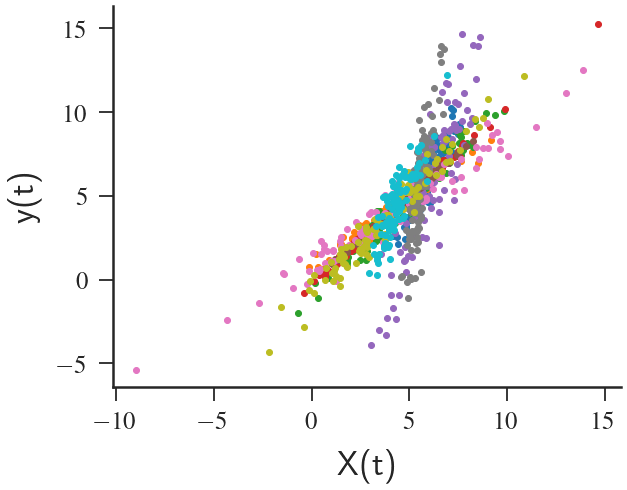

In [171]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1, ny=1, scale=1))
for t in range(0,10):
    ax.plot(params[t][0] + params[t][1] * X[t][:,0] + params[t][1] * X[t][:,1],y[t],'o')
    
ax.set_xlabel('X(t)')
ax.set_ylabel('y(t)')

In [172]:
Xpooled = X.reshape(1000,2)
ypooled = y.reshape(1000)

In [173]:
ypooled.shape

(1000,)

# model 

In [174]:
NITER     = 1000
THIN      = 1
NCHAINS   = 2  
NCORES    = 2 
WARMUP    = 500

In [175]:
def compile_stanmodel(model):
    # Compile model
    smodel = pystan.StanModel(model_code=model)
    return smodel

def MCMCinference(smodel,data):
    # Inference
    fit = smodel.sampling(data    = data, 
                          iter    = NITER, 
                          chains  = NCHAINS,
                          thin    = THIN,
                          n_jobs  = NCORES,
                          warmup  = WARMUP,
                          control = {"adapt_delta": 0.9, "max_treedepth":13}
                           )         
    return fit

In [177]:
X.shape,y.shape

((10, 100, 2), (10, 100))

In [178]:
data = {
        'N'     : Xpooled.shape[0],
        'K'     : Xpooled.shape[1],
        'x'     : Xpooled,
        'y'     : ypooled
       }

data_time = {
        'T'     : X.shape[0],
        'N'     : X.shape[1],
        'K'     : X.shape[2],
        'x'     : X,
        'y'     : y
       }

In [179]:
model1  = """
data {
    int<lower=0> N;   // number of data items
    int<lower=0> K;   // number of predictors
    real y[N];
    real x[N,K];
}

parameters{
    real<lower=0> sigma;
    real b0;
    real b1;
    real b2;
}
model {
    for (n in 1:N){
        y[n] ~ normal(b0 + b1*x[n,1]+b2*x[n,2],sigma);
    }
}
generated quantities{
    vector[N] log_lik;
    for (n in 1:N){
        log_lik[n] = normal_lpdf( y[n] | b0 + b1*x[n,1]+b2*x[n,2], sigma);
    }
}
"""


model2  = """
data {
    int<lower=0> N;   // number of data items
    int<lower=0> K;   // number of predictors
    real y[N];
    real x[N,K];
}

parameters{
    real<lower=0> sigma;
    real b0;
    real b1;
    real b2;
}
model {
    
    // model prior
    b0 ~ normal(0,100);
    b1 ~ normal(0,100);
    b2 ~ normal(0,100);

    // model error 
    sigma ~ gamma(0.25,0.25);
    
    for (n in 1:N){
        y[n] ~ normal(b0 + b1*x[n,1]+b2*x[n,2],sigma);
    }
}
generated quantities{
    vector[N] log_lik;
    for (n in 1:N){
        log_lik[n] = normal_lpdf( y[n] | b0 + b1*x[n,1]+b2*x[n,2], sigma);
    }
}
"""

model3  = """
data {
    int<lower=0> N;   // number of data items
    int<lower=0> K;   // number of predictors
    real y[N];
    real x[N,K];
}

parameters{
    real<lower=0> sigma;
    real b0;
    real b1;
    real b2;
    real mu_b0;
    real mu_b1;
    real mu_b2;
    real<lower=0> sigma_b0;
    real<lower=0> sigma_b1;
    real<lower=0> sigma_b2;
}
model {
    // hyperpriors
    mu_b0 ~ normal(0,100);
    mu_b1 ~ normal(0,100);
    mu_b2 ~ normal(0,100);
    sigma_b0 ~ gamma(0.25,0.25); 
    sigma_b1 ~ gamma(0.25,0.25);
    sigma_b2 ~ gamma(0.25,0.25);
    
    // model prior
    b0 ~ normal(mu_b0,sigma_b0);
    b1 ~ normal(mu_b1,sigma_b1);
    b2 ~ normal(mu_b2,sigma_b2);

    // model error 
    sigma ~ gamma(0.25,0.25);
    
    for (n in 1:N){
        y[n] ~ normal(b0 + b1*x[n,1]+b2*x[n,2],sigma);
    }
}
generated quantities{
    vector[N] log_lik;
    for (n in 1:N){
        log_lik[n] = normal_lpdf( y[n] | b0 + b1*x[n,1]+b2*x[n,2], sigma);
    }
}
"""

model4  = """
data {
    int<lower=0> T;   // number of time observations
    int<lower=0> N;   // number of data items
    int<lower=0> K;   // number of predictors
    real y[T,N];
    real x[T,N,K];
}

parameters{
    real<lower=0> sigma;
    real b0[T];
    real b1[T];
    real b2[T];
    real mu_b0;
    real mu_b1;
    real mu_b2;
    real<lower=0> sigma_b0;
    real<lower=0> sigma_b1;
    real<lower=0> sigma_b2;
}
model {
    // hyperpriors
    mu_b0 ~ normal(0,100);
    mu_b1 ~ normal(0,100);
    mu_b2 ~ normal(0,100);
    sigma_b0 ~ gamma(0.25,0.25); 
    sigma_b1 ~ gamma(0.25,0.25);
    sigma_b2 ~ gamma(0.25,0.25);
    
    // model prior
    for (t in 1:T){
        b0[t] ~ normal(mu_b0,sigma_b0);
        b1[t] ~ normal(mu_b1,sigma_b1);
        b2[t] ~ normal(mu_b2,sigma_b2);
    }
    
    // model error 
    sigma ~ gamma(0.25,0.25);
    
    for (t in 1:T){
        for (n in 1:N){
            y[t,n] ~ normal(b0[t] + b1[t]*x[t,n,1]+b2[t]*x[t,n,2],sigma);
        }
    }
}
generated quantities{
    vector[N] log_lik;
    for (n in 1:N){
        for (t in 1:T){
            log_lik[n] = normal_lpdf( y[t,n] | b0[t] + b1[t]*x[t,n,1]+b2[t]*x[t,n,2], sigma);
        }
    }
}
"""

In [180]:
# smodel1 = compile_stanmodel(model1)
fit1 =  MCMCinference(smodel1,data)


Gradient evaluation took 0.000256 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000236 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.36 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.380517 seconds (Warm-up)
               0.353866 seconds (Sampling)
               0.734383 seconds (Total)

Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.400837 seconds (Warm-up)
               0.344373 seconds (Sampling)
               0.74521 seconds (Total)



In [182]:
# smodel2 = compile_stanmodel(model2)
fit2 =  MCMCinference(smodel2,data)


Gradient evaluation took 0.000297 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.97 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000232 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.32 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 26)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.362303 seconds (Warm-up)
               0.347276 seconds (Sampling)
               0.709579 seconds (Total)

Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.401599 seconds (Warm-up)
               0.353248 seconds (Sampling)
               0.754847 seconds (Total)



In [183]:
# smodel3 = compile_stanmodel(model3)
fit3 =  MCMCinference(smodel3,data)


Gradient evaluation took 0.000258 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000243 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.43 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 7.15141 seconds (Warm-up)
               9.23957 seconds (

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 29.4312 seconds (Warm-up)
               13.8841 seconds (Sampling)
               43.3153 seconds (Total)



In [184]:
# smodel4 = compile_stanmodel(model4)
fit4 =  MCMCinference(smodel4,data_time)


Gradient evaluation took 0.000246 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000251 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.51 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 33)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 34)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.



Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 1.85399 seconds (Warm-up)
               0.895641 seconds (Sampling)
               2.74963 seconds (Total)

Iteration: 1000 / 1000 [100%]  (S

In [185]:
b0 = round(fit1['b0'].mean(),2)
b1 = round(fit1['b1'].mean(),2)
b2 = round(fit1['b2'].mean(),2)
print(b0,b1,b2)

4.82 1.22 2.0


In [186]:
b0 = round(fit2['b0'].mean(),2)
b1 = round(fit2['b1'].mean(),2)
b2 = round(fit2['b2'].mean(),2)
print(b0,b1,b2)

4.82 1.22 2.0


In [187]:
b0 = round(fit3['b0'].mean(),2)
b1 = round(fit3['b1'].mean(),2)
b2 = round(fit3['b2'].mean(),2)
print(b0,b1,b2)

4.82 1.22 2.0


In [188]:
b0 = round(fit4['b0'].mean(),2)
b1 = round(fit4['b1'].mean(),2)
b2 = round(fit4['b2'].mean(),2)
print(b0,b1,b2)

4.87 1.18 2.0


# Convergence of MCMC

In [216]:
def cdf(data, nbins=15, log=False, surv=True):
    """
    Estimates the survival distribution from a np.array.

    Parameters
    ----------
    data: np.array
    nbins: number of bins.
    log: True for log-spaced bins (Default: False).
    surv: False for cumulative distribution function (Default: True).
    ----------
    Returns [bins,pdf].
    """
    size = len(data)
    if log:
        bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
    else:
        bins = np.linspace(np.min(data), np.max(data),nbins)        
    densities = np.array([len(data[data>=binvalue])/size for binvalue in bins])
    if not surv:
        densities = 1 - densities
    return bins, densities 

## R hat

In [232]:
def get_df_summary(fit):
    summary_data=fit.summary()
    df_summary=pd.DataFrame(summary_data['summary'],
                            columns=summary_data['summary_colnames'],
                            index=summary_data['summary_rownames'])
    return df_summary
df = get_df_summary(fit1)
df = get_df_summary(fit1)
df=df[~df.index.str.contains('yhat')]
df=df[~df.index.str.contains('log_lik')]
df

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
sigma,1.259607,0.000867,0.028925,1.207877,1.239083,1.258495,1.277729,1.317035,1112.624380,0.999961
b0,4.824417,0.001171,0.038925,4.747956,4.795590,4.824581,4.852700,4.899548,1104.490231,1.000263
b1,1.219924,0.001144,0.039986,1.142630,1.191565,1.219952,1.247259,1.297914,1221.828948,0.999884
b2,1.998323,0.001233,0.036772,1.925854,1.973925,2.000052,2.021722,2.066585,888.964546,0.998690
lp__,-730.274547,0.066416,1.432568,-734.130752,-730.912161,-729.938550,-729.274096,-728.581394,465.247599,0.999555


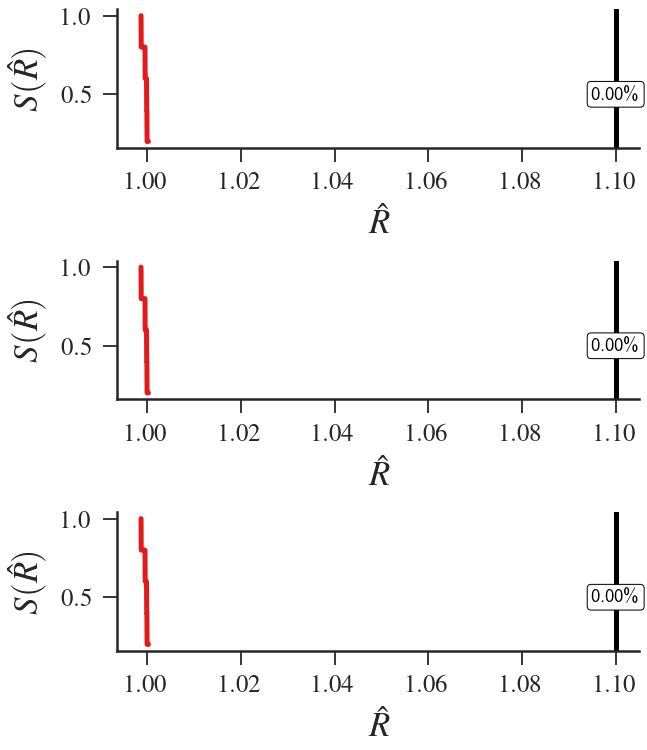

In [240]:
f, axs = plt.subplots(nrows=3, ncols=1, figsize=stdfigsize(nx=1, ny=1.5, scale=1),sharex=False)
colors={'Murder':'#e31a1c'}
for i in range(0,3):
    ax=axs.flatten()[i]
    df = get_df_summary(fit1)
    df=df[~df.index.str.contains('yhat')]
    df=df[~df.index.str.contains('log_lik')]

    bins, densities = cdf(df['Rhat'].values,nbins=40)
    ax.plot(bins, densities,color='#e31a1c')

    ax.axvline(1.1,color='k',ls='-')
    
    ax.text(1.1, 0.5, r"{:.2f}\%".format(sum(df['Rhat'].values>1.1)/len(df['Rhat'].values)),
        color='k', fontsize=20,
        horizontalalignment="center", verticalalignment="center",
        bbox=dict(boxstyle="round", fc="white", ec='k', pad=0.2))
    ax.set_xlabel(r'$\hat{R}$')
    ax.set_ylabel(r'$S(\hat{R})$')

f.tight_layout(h_pad=2,w_pad=3)

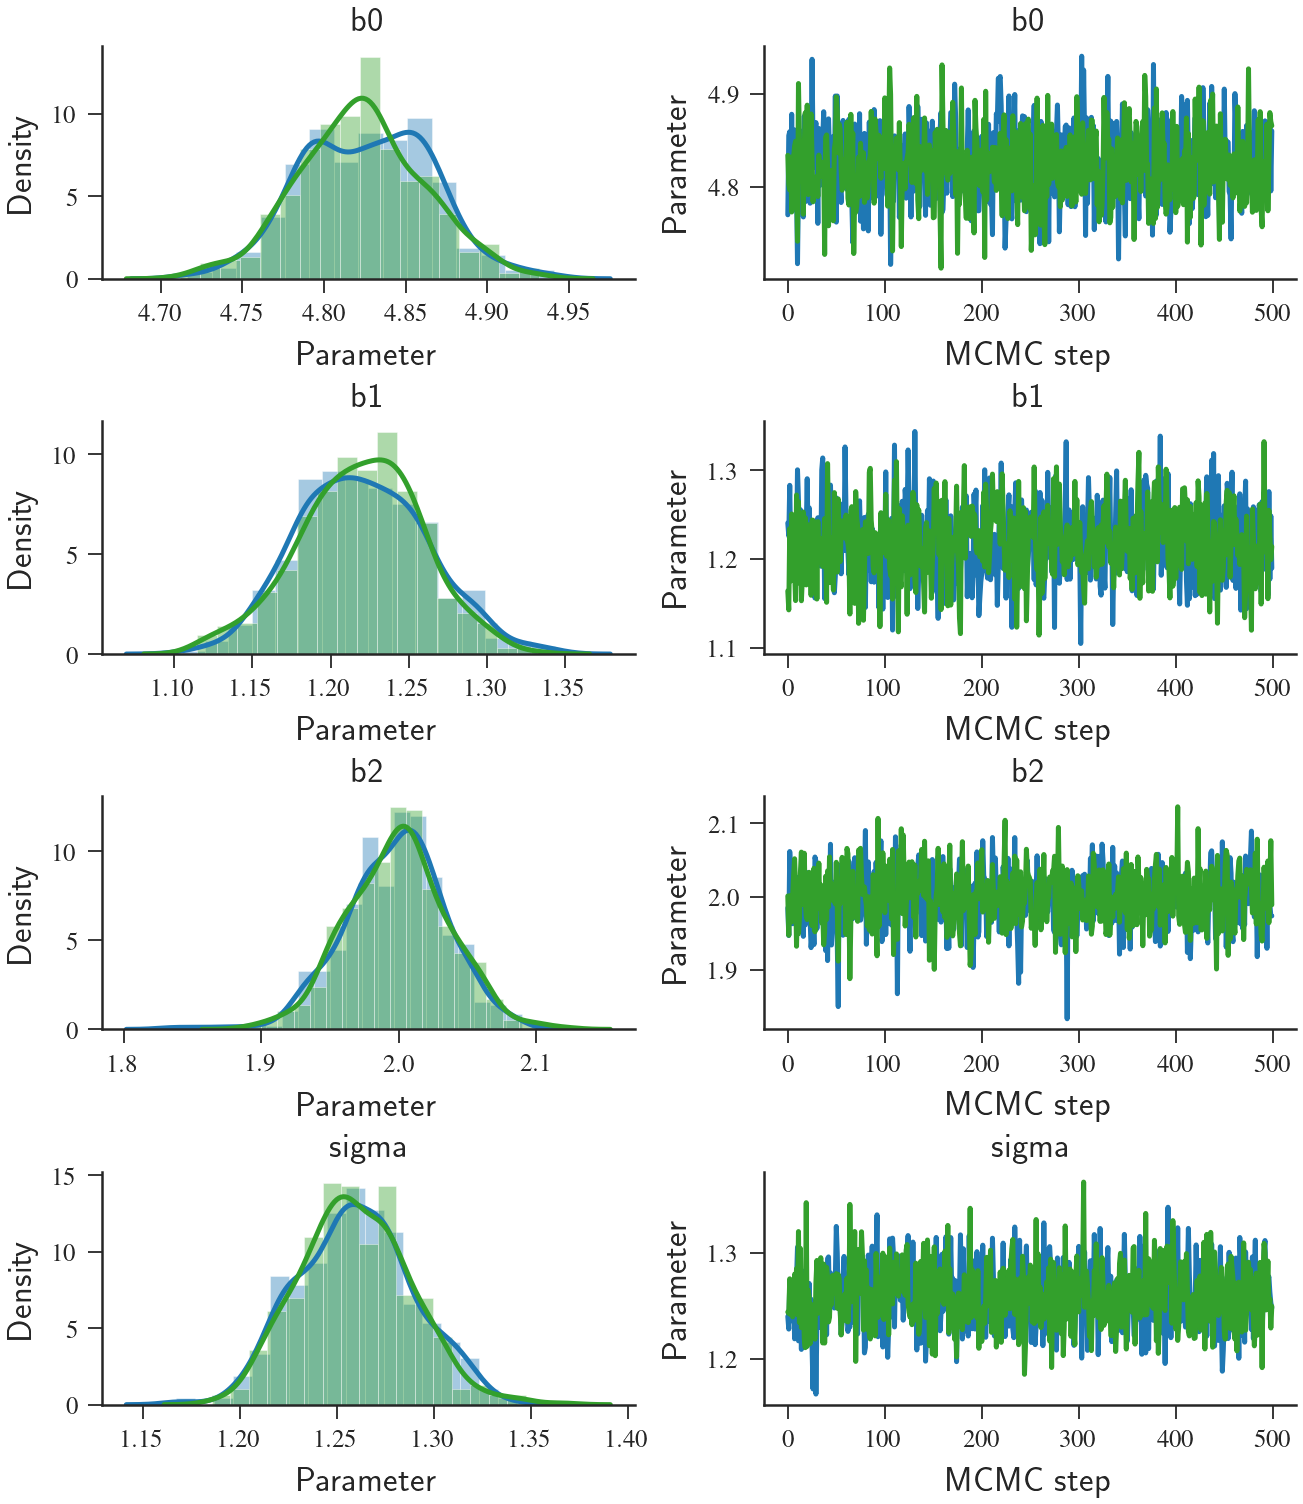

In [260]:
tslen=500
f, axs = plt.subplots(nrows=4, ncols=2, figsize=stdfigsize(nx=2, ny=3, scale=1),sharex=False)

count=0
for param in ['b0','b1','b2','sigma']:
    ax = axs.flatten()[count]
    sns.distplot(fit1[param][:tslen],ax=ax,color='#1f78b4')
    sns.distplot(fit1[param][tslen:],ax=ax,color='#33a02c')
    ax.set_ylabel(r'Density')
    ax.set_xlabel(r'Parameter')
    ax.set_title(param)
    count=count+1
    
    ax = axs.flatten()[count]
    ax.plot(fit1[param][:tslen],color='#1f78b4')
    ax.plot(fit1[param][tslen:],color='#33a02c',alpha=1)
    ax.set_ylabel(r'Parameter')
    ax.set_xlabel('MCMC step')
    ax.set_title(param)
    count=count+1
    


f.tight_layout()


array([[<AxesSubplot:title={'center':'b0'}>,
        <AxesSubplot:title={'center':'b0'}>],
       [<AxesSubplot:title={'center':'b1'}>,
        <AxesSubplot:title={'center':'b1'}>],
       [<AxesSubplot:title={'center':'b2'}>,
        <AxesSubplot:title={'center':'b2'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

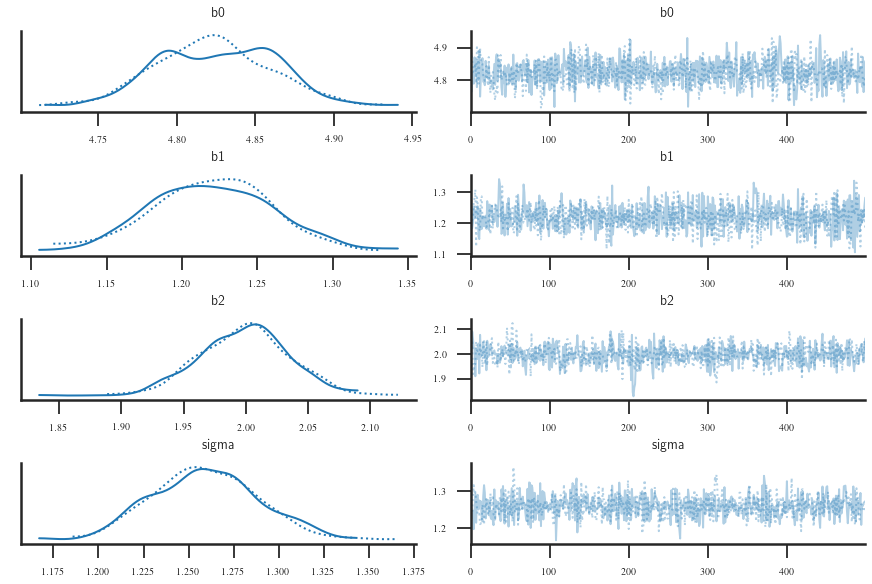

In [259]:
az.plot_trace(fit1,var_names=['b0','b1','b2','sigma'])

## Markov Chain autocorrelation 

In [262]:
from statsmodels.tsa.stattools import acf

In [265]:
fit1['b0'].shape

(1000,)

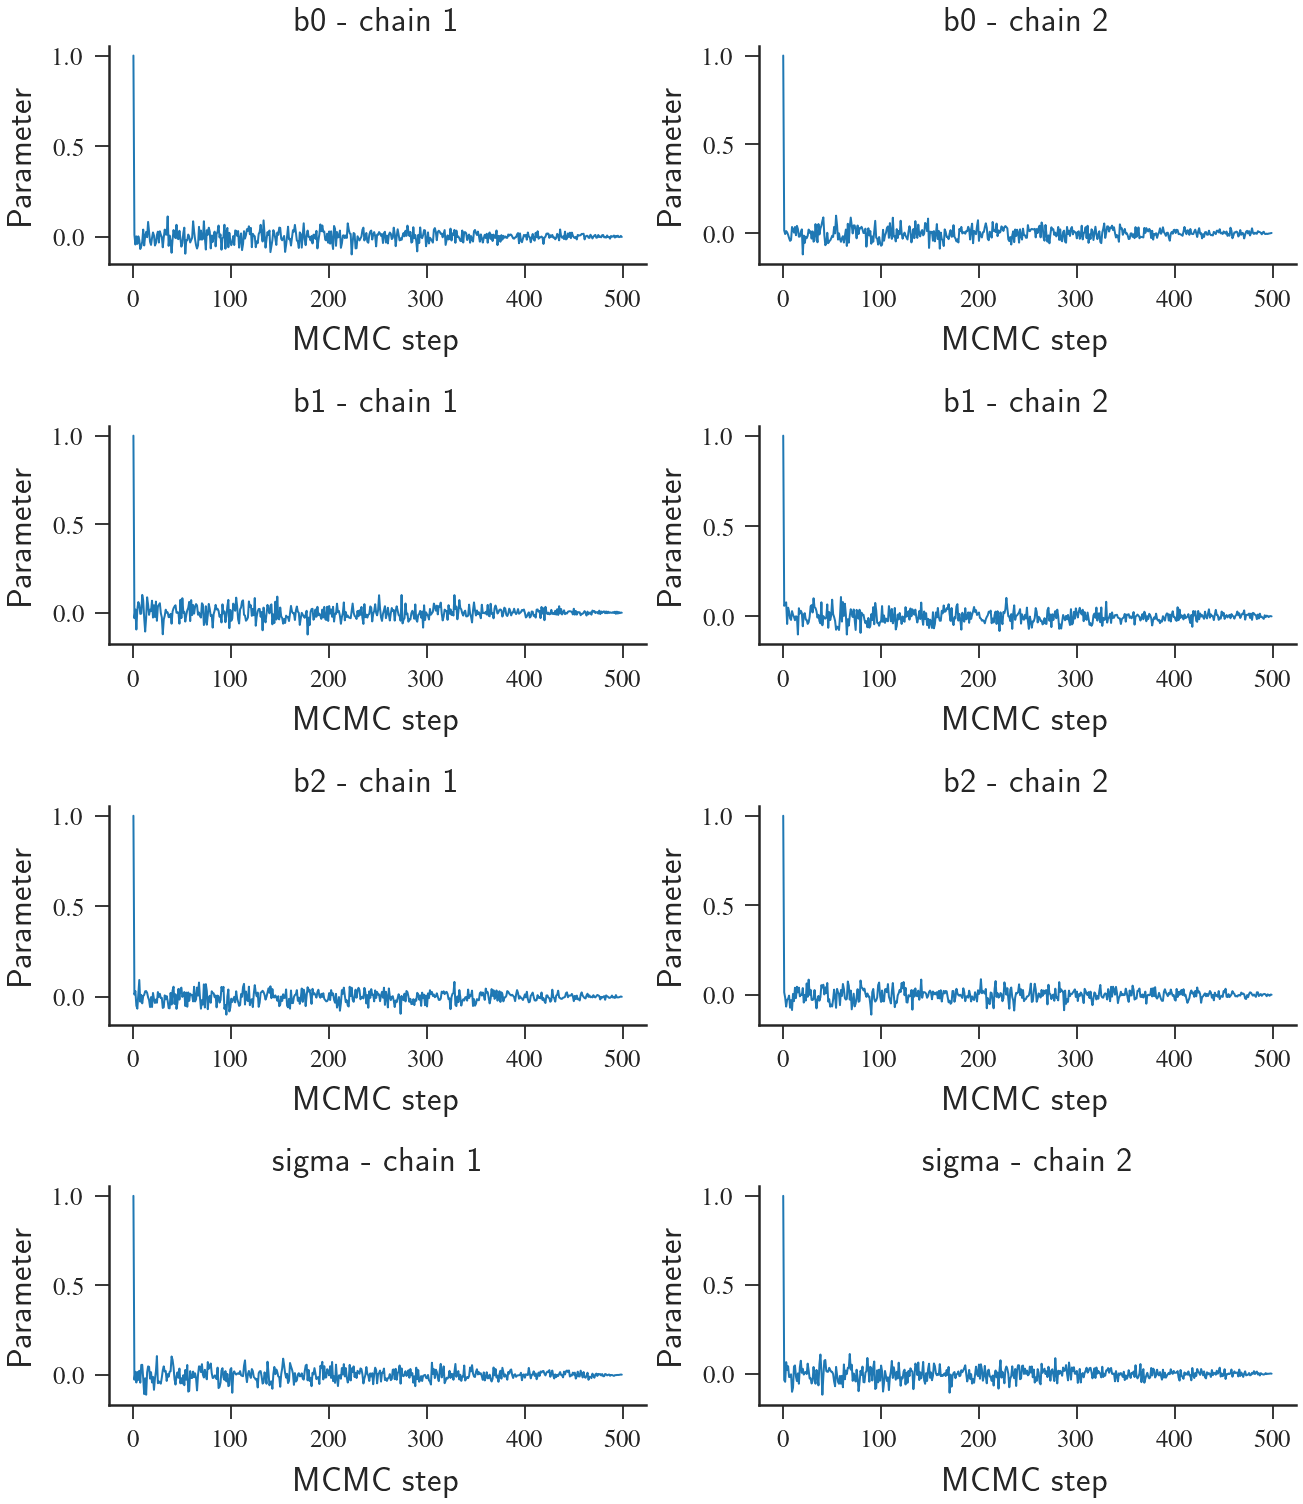

In [267]:
tslen=500
f, axs = plt.subplots(nrows=4, ncols=2, figsize=stdfigsize(nx=2, ny=3, scale=1),sharex=False)


count=0
for param in ['b0','b1','b2','sigma']:
    ax = axs.flatten()[count]
    ax.plot(acf(fit1[param][:tslen], nlags=1000),color='#1f78b4',lw=2)
    ax.set_title(param+' - chain 1')
    ax.set_xlabel('MCMC step')
    ax.set_ylabel(r'Parameter')  
    count = count+1
    ax = axs.flatten()[count]
    ax.plot(acf(fit1[param][tslen:], nlags=1000),color='#1f78b4',lw=2)
    ax.set_title(param+' - chain 2')
    ax.set_xlabel('MCMC step')
    ax.set_ylabel(r'Parameter')  
    count = count+1


    
f.tight_layout(h_pad=3)



array([[<AxesSubplot:title={'center':'b0\n0'}>,
        <AxesSubplot:title={'center':'b0\n1'}>,
        <AxesSubplot:title={'center':'b1\n0'}>,
        <AxesSubplot:title={'center':'b1\n1'}>],
       [<AxesSubplot:title={'center':'b2\n0'}>,
        <AxesSubplot:title={'center':'b2\n1'}>,
        <AxesSubplot:title={'center':'sigma\n0'}>,
        <AxesSubplot:title={'center':'sigma\n1'}>]], dtype=object)

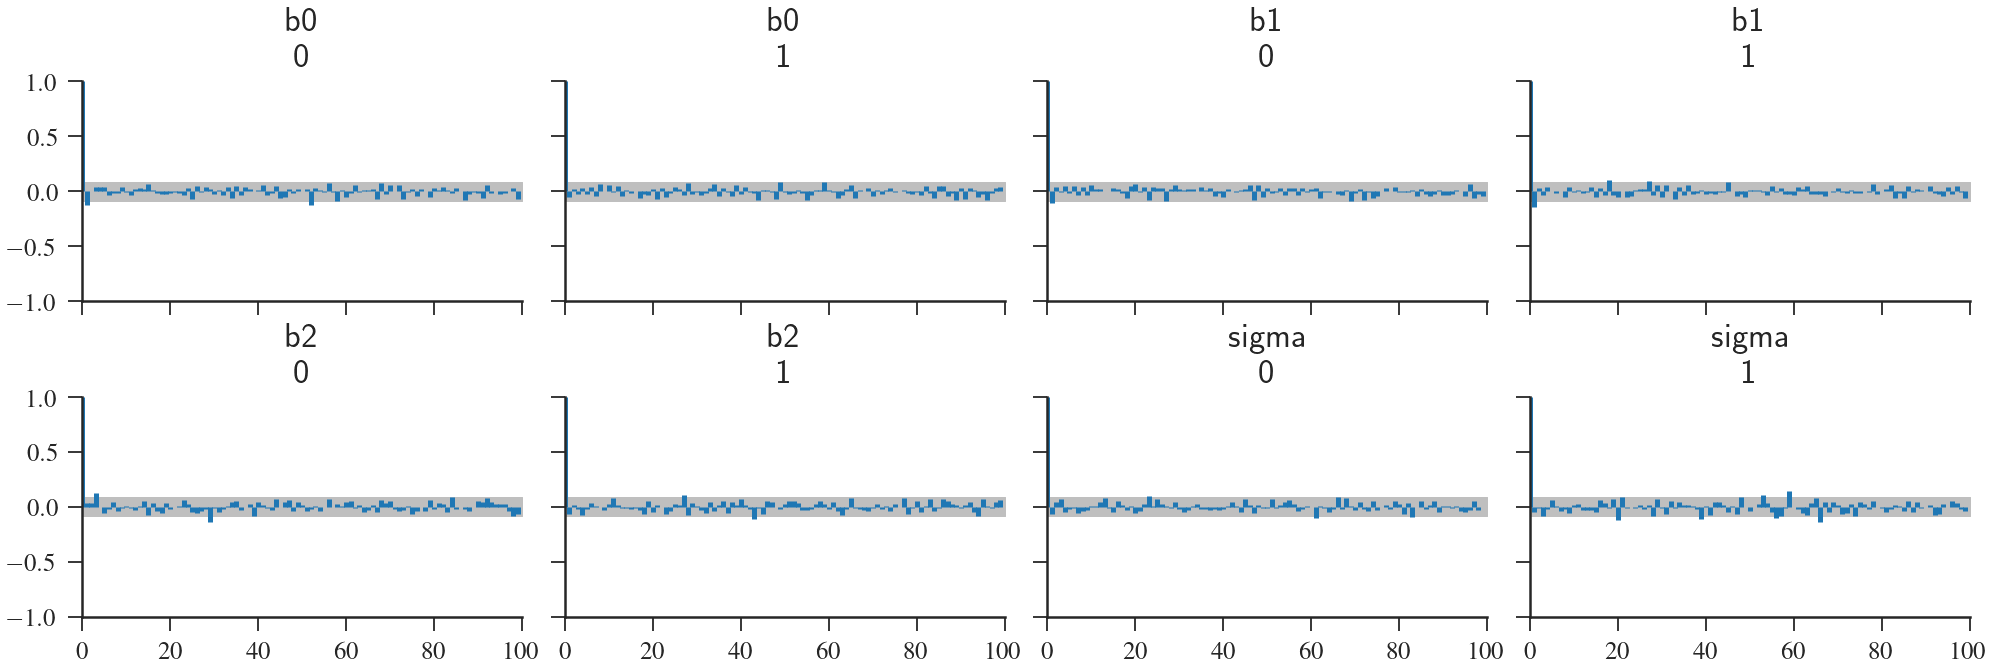

In [261]:
az.plot_autocorr(fit1,var_names=['b0','b1','b2','sigma'])

# WAIC

In [189]:
def compute_waic(fit):
    log_lik  = fit['log_lik']
    scale_value=1
    shape         = log_lik.shape
    n_samples     = shape[0]
    n_data_points = shape[1]
    vars_lpd      = np.var(log_lik,axis=0)
    lppd_i        = np.log(np.mean(np.exp(log_lik),axis=0))


    waic_i        = scale_value * (lppd_i - vars_lpd)
    waic_se       = (n_data_points * np.var(waic_i)) ** 0.5
    waic_sum      = np.sum(waic_i)
    p_waic        = np.sum(vars_lpd)
    return [waic_sum,waic_se,p_waic]

In [198]:
waic1 = compute_waic(fit1)
waic2 = compute_waic(fit2)
waic3 = compute_waic(fit3)
waic4 = compute_waic(fit4)

In [199]:
import pandas as pd

In [214]:
waic_data = np.array([waic1,
waic2,
waic3,
waic4])

waic_df = pd.DataFrame(waic_data,columns = ['waic','se','p'],index=['Pooled','Pooled and priors','Pooled, priors, and hyperpriors','Hierarchical model'])
waic_df = waic_df.sort_values(by='waic')
waic_df

,waic,se,p
"Pooled, priors, and hyperpriors",-1652.545625,28.183048,6.022747
Pooled and priors,-1652.308116,28.039174,5.647961
Pooled,-1652.259906,28.001149,5.576625
Hierarchical model,84.128347,8.367286,2.665397


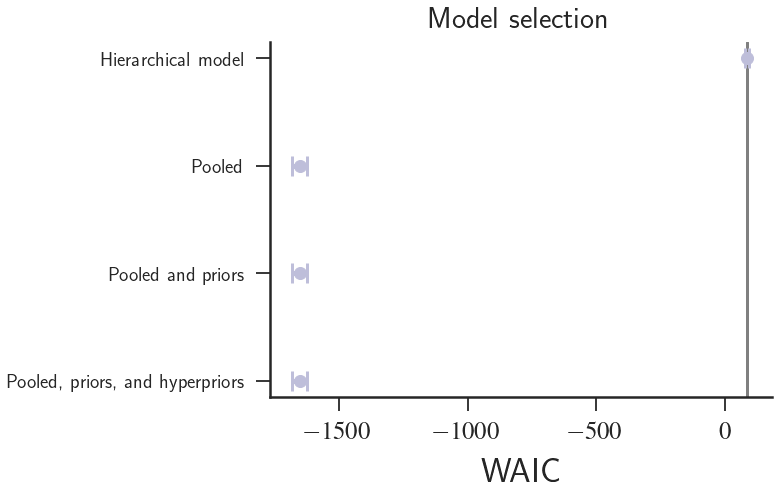

In [215]:
color = '#bebeda'
f, ax = plt.subplots(nrows=1, ncols=1, figsize=stdfigsize(nx=1.2, ny=1, scale=1))

waic=waic_df['waic'].values
se=waic_df['se'].values

x=np.arange(0,len(waic_df))
ax.errorbar(waic,
            x, 
            yerr=None, 
            xerr=se, 
            fmt='',
            ecolor=color, 
            elinewidth=5, 
            linewidth=0,
            capsize=10, 
            barsabove=False, lolims=False, uplims=False, xlolims=False, 
            xuplims=False, errorevery=1, capthick=3, data=None)
ax.plot(waic,x,'o',color=color,markersize=12)
ax.axvline(waic[-1],color='gray',ls='solid',lw=3,zorder=-1)
ax.set_yticks(np.arange(0,len(waic_df)))
ax.set_yticklabels(labels=waic_df.index,rotation=0,ha='right',fontsize=20)
ax.set_title('Model selection',fontsize=30)
ax.set_xlabel('WAIC')
f.tight_layout(w_pad=0,h_pad=2)


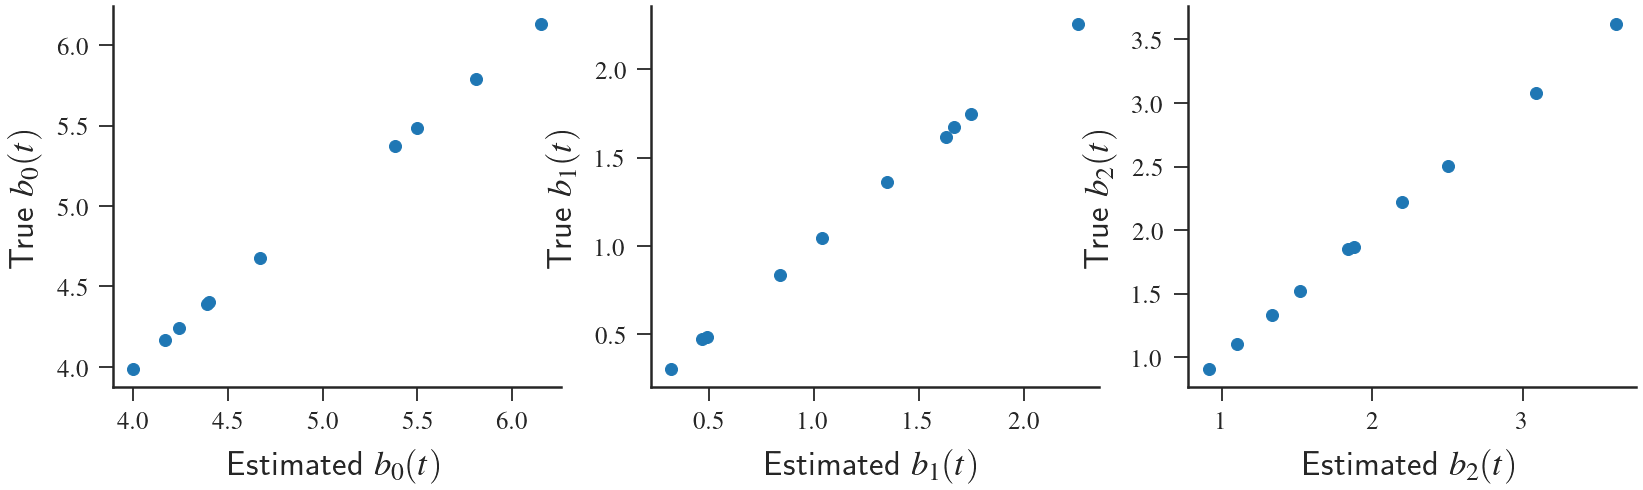

In [196]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=stdfigsize(nx=3, ny=1, scale=1))
params = np.array(params)
for i in range(0,3):
    ax = axs.flatten()[i]
    ax.plot(params[:,i],fit4['b{}'.format(i)].mean(axis=0),'o',ms=12)
    ax.set_xlabel('Estimated $b_{}(t)$'.format(i))
    ax.set_ylabel('True $b_{}(t)$'.format(i))

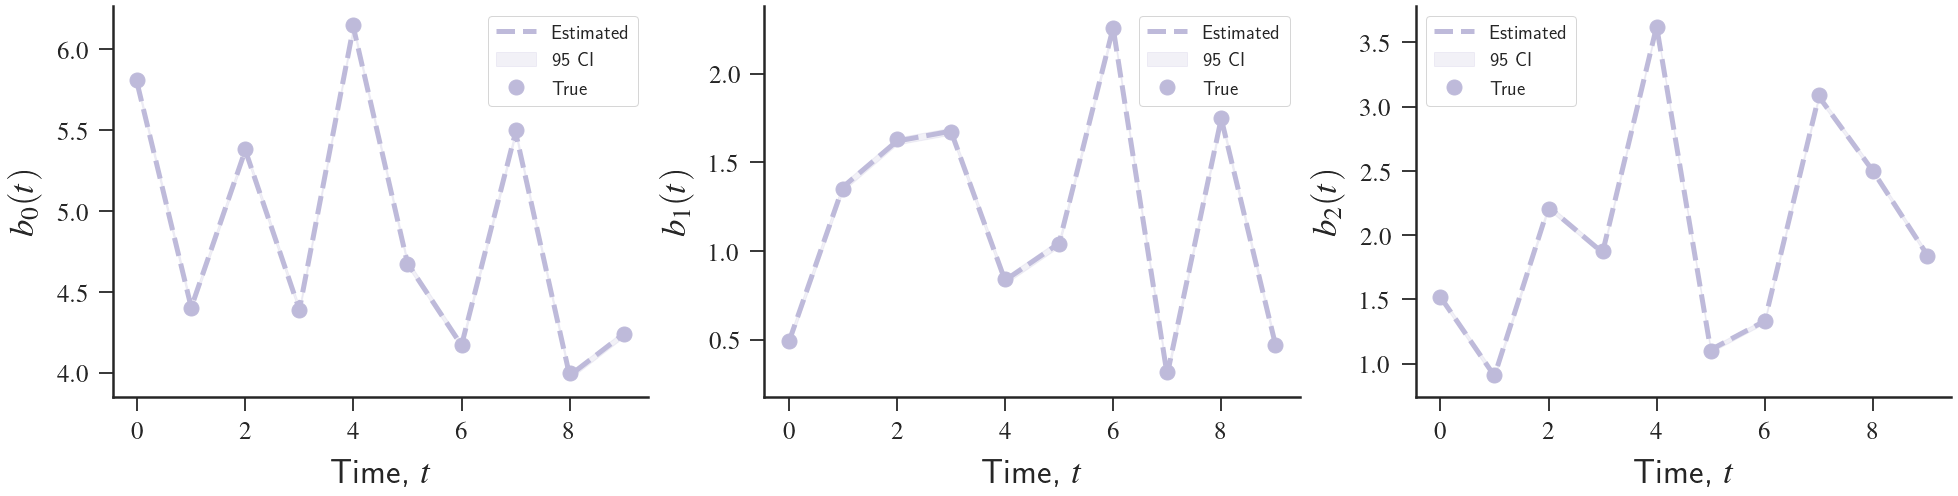

In [197]:
f, axs = plt.subplots(nrows=1, ncols=3, figsize=stdfigsize(nx=3, ny=1, scale=1))

for i in range(0,3):
    ax = axs.flatten()[i]
    ax.plot(np.arange(0,10),fit4['b{}'.format(i)].mean(axis=0),'--',label = 'Estimated',color = '#bebada')
    ax.fill_between(np.arange(0,10),np.percentile(fit4['b{}'.format(i)],2.5,axis=0),np.percentile(fit4['b{}'.format(i)],97.5,axis=0),label = '95 CI',alpha=0.2,color = '#bebada')

    ax.plot(np.arange(0,10),params[:,i],'o',ms=15,label = 'True',color = '#bebada')
    ax.set_xlabel('Time, $t$')
    ax.set_ylabel('$b_{}(t)$'.format(i))
    ax.legend()
f.tight_layout()
